# Jupyter Notebook 运行矩阵相乘的结果
### 运行环境：
1. Google Cloud
2. GPU: Nvidia Telsa P100, 显存: 16G
3. CPU: 双核 Intel(R) Xeon(R) CPU @ 2.00GHz
4. 内存: 10G
5. Python: 2018.12月的Anaconda3
6. CUDA: cudatoolkit 10.0

# 1 代码

这个NYU的教程帮助我理解GPU编程很多

https://nyu-cds.github.io/python-numba/05-cuda/

In [1]:
'''
Matrix multiplication sample, some numba and CUDA testing code
'''
import math
import time
import numpy as np
from numba import cuda, jit, float64

TPB = 32 # thread per block

def cpu_mat_mul(A, B, C):
    '''matrix mulplication on cpu, O(n^3) implementation
    '''
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            summation = 0
            for k in range(A.shape[1]):
                summation += A[i, k] * B[k, j]
            C[i, j] = summation

@jit
def cpu_mat_mul_jit(A, B, C):
    '''matrix mulplication on cpu O(n^3) implementation with @jit decocation
    '''
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            summation = 0
            for k in range(A.shape[1]):
                summation += A[i, k] * B[k, j]
            C[i, j] = summation

@cuda.jit
def mat_mul_naive_kernal(A, B, C):
    '''matrix multiplication on gpu, naive method using global device memory
    '''
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        summation = 0
        for k in range(A.shape[1]):
            summation += A[i, k] * B[k, j]
        C[i, j] = summation

@cuda.jit
def mat_mul_shared_kernal(A, B, C):
    '''matrix multiplication on gpu, optimized version using shared memory.
    '''
    s_A = cuda.shared.array((TPB, TPB), dtype=float64)  # s_ --> shared
    s_B = cuda.shared.array((TPB, TPB), dtype=float64)
    x, y = cuda.grid(2)
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y
    #print((x, y), (tx, ty), (bx, by), (bw, bh))

    if x >= C.shape[0] or y >= C.shape[1]:
        return

    tmp = 0
    for i in range(int(A.shape[1]/TPB)):
        #print((x, y), (tx, ty), i)
        s_A[tx, ty] = A[x, ty + bw*i]
        s_B[tx, ty] = B[tx + bh*i, y]
        cuda.syncthreads()

        for j in range(TPB):
            tmp += s_A[tx, j] * s_B[j, ty]

        cuda.syncthreads()
    C[x, y] = tmp


def host_naive(A, B, C):
    '''host code for calling naive kernal
    '''
    d_A = cuda.to_device(A)  # d_ --> device
    d_B = cuda.to_device(B)
    d_C = cuda.device_array(C.shape, np.float64)

    threadsperblock = (TPB, TPB)
    blockspergrid_x = math.ceil(A.shape[0]/threadsperblock[0])
    blockspergrid_y = math.ceil(B.shape[1]/threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    mat_mul_naive_kernal[blockspergrid, threadsperblock](d_A, d_B, d_C)

    return d_C.copy_to_host()


def host_optimized(A, B, C):
    '''host code for calling naive kernal
    '''
    d_A = cuda.to_device(A)  # d_ --> device
    d_B = cuda.to_device(B)
    d_C = cuda.device_array(C.shape, np.float64)

    threadsperblock = (TPB, TPB)
    blockspergrid_x = math.ceil(A.shape[0]/threadsperblock[0])
    blockspergrid_y = math.ceil(B.shape[1]/threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    mat_mul_shared_kernal[blockspergrid, threadsperblock](d_A, d_B, d_C)

    return d_C.copy_to_host()



#  2 小数据集测试正确性

In [3]:
def main():
    '''main
    '''
    A = np.full((TPB*4, TPB*6), 0.5, dtype=np.float64)
    B = np.full((TPB*6, TPB*2), 2, dtype=np.float64)
    C = np.full((TPB*4, TPB*2), 0, dtype=np.float64)

    start = time.time()
    cpu_mat_mul(A, B, C)
    print('cpu mat mul:', time.time()-start)

    start = time.time()
    cpu_mat_mul_jit(A, B, C)
    print('cpu mat mul with numba.jit:', time.time()-start)

    start = time.time()
    ans = host_naive(A, B, C)
    print('gpu mat mul global:', time.time()-start)
    print(ans)
    
    start = time.time()
    ans = host_optimized(A, B, C)
    print('gpu mat mul shared:', time.time()-start)
    print(ans)

main()

cpu mat mul: 0.9127058982849121
cpu mat mul with numba.jit: 0.0022644996643066406
gpu mat mul global: 0.9633159637451172
[[192. 192. 192. ... 192. 192. 192.]
 [192. 192. 192. ... 192. 192. 192.]
 [192. 192. 192. ... 192. 192. 192.]
 ...
 [192. 192. 192. ... 192. 192. 192.]
 [192. 192. 192. ... 192. 192. 192.]
 [192. 192. 192. ... 192. 192. 192.]]
gpu mat mul shared: 0.21467018127441406
[[192. 192. 192. ... 192. 192. 192.]
 [192. 192. 192. ... 192. 192. 192.]
 [192. 192. 192. ... 192. 192. 192.]
 ...
 [192. 192. 192. ... 192. 192. 192.]
 [192. 192. 192. ... 192. 192. 192.]
 [192. 192. 192. ... 192. 192. 192.]]


## 结论
1. 结果矩阵的每一个元素是$32\times6\times(2\times0.5) = 192$，结果正确。
2. 此时最快的是CPU+numba.jit的版本，为0.00226秒，GPU版本的没有优势，因为data transmission 的overhead

# 3 中数据集看看GPU能加速多少

In [4]:
def main():
    '''main
    '''
    A = np.full((TPB*40, TPB*60), 0.5, dtype=np.float64)
    B = np.full((TPB*60, TPB*20), 2, dtype=np.float64)
    C = np.full((TPB*40, TPB*20), 0, dtype=np.float64)

    start = time.time()
    cpu_mat_mul(A, B, C)
    print('cpu mat mul:', time.time()-start)

    start = time.time()
    cpu_mat_mul_jit(A, B, C)
    print('cpu mat mul with numba.jit:', time.time()-start)

    start = time.time()
    ans = host_naive(A, B, C)
    print('gpu mat mul global:', time.time()-start)
    print(ans)
    
    start = time.time()
    ans = host_optimized(A, B, C)
    print('gpu mat mul shared:', time.time()-start)
    print(ans)

main()

cpu mat mul: 873.3324582576752
cpu mat mul with numba.jit: 11.214848041534424
gpu mat mul global: 0.04427981376647949
[[1920. 1920. 1920. ... 1920. 1920. 1920.]
 [1920. 1920. 1920. ... 1920. 1920. 1920.]
 [1920. 1920. 1920. ... 1920. 1920. 1920.]
 ...
 [1920. 1920. 1920. ... 1920. 1920. 1920.]
 [1920. 1920. 1920. ... 1920. 1920. 1920.]
 [1920. 1920. 1920. ... 1920. 1920. 1920.]]
gpu mat mul shared: 0.04383087158203125
[[1920. 1920. 1920. ... 1920. 1920. 1920.]
 [1920. 1920. 1920. ... 1920. 1920. 1920.]
 [1920. 1920. 1920. ... 1920. 1920. 1920.]
 ...
 [1920. 1920. 1920. ... 1920. 1920. 1920.]
 [1920. 1920. 1920. ... 1920. 1920. 1920.]
 [1920. 1920. 1920. ... 1920. 1920. 1920.]]


## 结论
1. numba.jit $\ \ \ \ $加速 $873.3\div11.2 = 78$ 倍
2. GPU global $\ $加速 $873.3\div0.04427 = 19726$ 倍
3. GPU shared 加速 $873.3\div0.04383 = 19924$ 倍

# 4 大数据只测试GPU

In [3]:
def main():
    '''main
    '''
    A = np.full((TPB*512, TPB*512), 0.5, dtype=np.float64)
    B = np.full((TPB*512, TPB*512), 2, dtype=np.float64)
    C = np.full((TPB*512, TPB*512), 0, dtype=np.float64)

    start = time.time()
    host_naive(A, B, C)
    print('gpu mat mul global:', time.time()-start)
    
    start = time.time()
    host_optimized(A, B, C)
    print('gpu mat mul shared:', time.time()-start)

main()

gpu mat mul global: 74.07195711135864
gpu mat mul shared: 69.90934872627258


## 结论
1. Shared 比 global 加速 $74.07\div69.90 = 1.06$ 倍

# 5 来做一个图

In [2]:
def plot(N):
    '''main
    '''
    A = np.full((TPB*N, TPB*N), 0.5, dtype=np.float64)
    B = np.full((TPB*N, TPB*N), 2, dtype=np.float64)
    C = np.full((TPB*N, TPB*N), 0, dtype=np.float64)

    cpu, cpu_jit, gpu_global, gpu_share = None, None, None, None
    
    if N <= 16:
        start = time.time()
        cpu_mat_mul(A, B, C)
        cpu = time.time() - start

    if N <= 64:
        start = time.time()
        cpu_mat_mul_jit(A, B, C)
        cpu_jit = time.time() - start

    start = time.time()
    host_naive(A, B, C)
    gpu_global = time.time() - start
    
    start = time.time()
    host_optimized(A, B, C)
    gpu_share = time.time() - start
    return cpu, cpu_jit, gpu_global, gpu_share

In [3]:
N = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
X = [TPB*n for n in N]
Y_CPU = []
Y_CPU_jit = []
Y_GPU_global = []
Y_GPU_shared = []

for n in N:
    cpu, cpu_jit, gpu_global, gpu_share = plot(n)
    if cpu:
        Y_CPU.append(cpu)
    if cpu_jit:
        Y_CPU_jit.append(cpu_jit)
    Y_GPU_global.append(gpu_global)
    Y_GPU_shared.append(gpu_share)

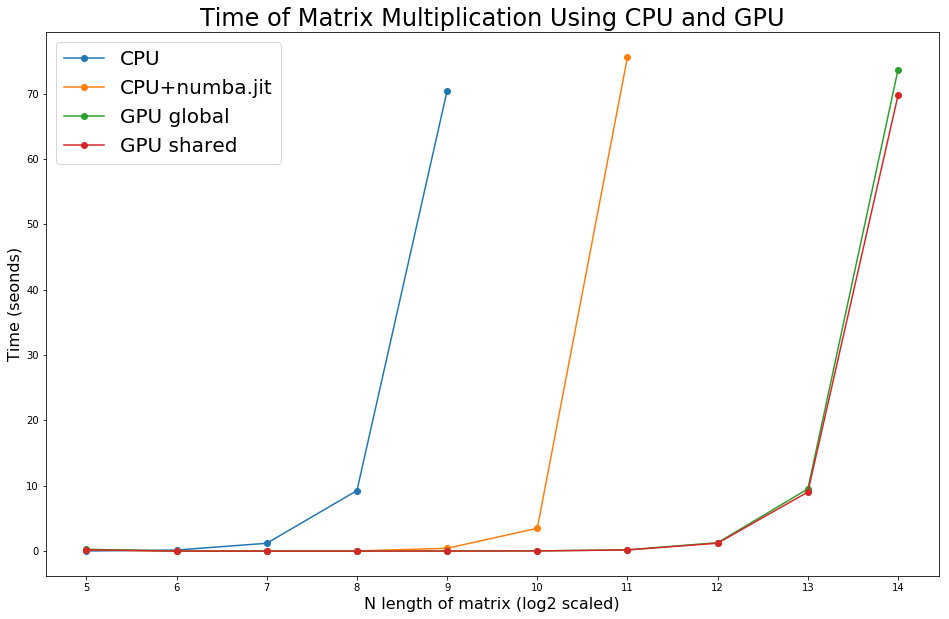

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 10))

X = [TPB*n for n in [1, 2, 4, 8, 16]]
plt.plot(np.log2(X), Y_CPU, marker='o')

X = [TPB*n for n in [1, 2, 4, 8, 16, 32, 64]]
plt.plot(np.log2(X), Y_CPU_jit, marker='o')

X = [TPB*n for n in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]]
plt.plot(np.log2(X), Y_GPU_global, marker='o')

X = [TPB*n for n in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]]
plt.plot(np.log2(X), Y_GPU_shared, marker='o')
plt.xlabel('N length of matrix (log2 scaled)', fontsize=16)
plt.ylabel('Time (seonds)', fontsize=16)
plt.xticks(range(5, 15, 1))
plt.title('Time of Matrix Multiplication Using CPU and GPU', fontsize=24)

plt.legend(['CPU', 'CPU+numba.jit', 'GPU global', 'GPU shared'], prop={'size':20})
plt.savefig('MatMul.png')

### 注：对X坐标做了np.log2
1. $2^9 = 512$，此时 CPU 超过一分钟了
2. $2^{11} = 2048$，此时 CPU+numba.jit 超过一分钟了
3. $2^{14} = 16384$，此时 GPU 超过一分钟了

In [14]:
np.power(2, 14)

16384

In [26]:
import sys
sys.getsizeof(np.zeros((16384, 16384), dtype=np.float))

2147483760

#### 一个(16384, 16384)的数组，已经超过2G的内存了，这样大的数组在CPU和GPU之间传输是需要花不少时间的